In [1]:

######################################################
### Attaching and downloading necessary packagaes ####
######################################################
# if (!requireNamespace("BiocManager", quietly = FALSE))
#     install.packages("BiocManager")
# BiocManager::version()
# library("devtools")
# devtools::install_github("broadinstitute/infercnv", force=TRUE)
# detach("package:infercnv", unload=T)  ### package infercnv_1.15.3  seems to work fine
library(infercnv)
#### loading packages and others 
library("Seurat")
library("tidyverse")
#remotes::install_github("mojaveazure/seurat-disk")
library("SeuratDisk")
#install.packages("ggplot2")
library(ggplot2)
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
library(DoubletFinder)
library(dplyr)
library(tidyverse)
library(ggpubr)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filte

In [2]:
## Step 1 . Read a scRNA file 
dat <- Read10X_h5("/data/kumarr9/scRNA/atac.scRNA.parth/data_integration_sample/SCAF2229_81-68-62-3/outs/filtered_feature_bc_matrix.h5")

## step 2 . creating seurat object with with desired cell and gene parameters and also name the project
dat_seurat_obj <- CreateSeuratObject(counts = dat, min.cells = 3, min.features = 200, project = 'SCLC')

## step 3 . Identifying mitochindrial contamination-- and adding it to seurat object -- use MT when human and mt when mouse
dat_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(dat_seurat_obj, pattern = "^MT-")
#View(dat_seurat_obj@meta.data) ## to visualize the data to see mitochondrial cells contamination

## step 4. plotting the mitochondrial contamination or data distribution
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/data_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

## step 5. viewing data distribution before mitochondrial contamination removal
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/data_distribution.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features <- plot1 + plot2
SCAF3163_features
dev.off()

## step 6. Removing low quality cells and mitochondrial contamination
dat_seurat_obj_filtered <- subset(dat_seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### just to see what number of cells left after feature selection 
#dat_seurat_obj
#dat_seurat_obj_filtered

## step 7. plots the results after filtering or filtered features
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/data_filtered_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/data_distribution_filtered_features.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features_filtered <- plot1 + plot2
SCAF3163_features_filtered
dev.off()
#### Before any kind of scRNA, need to do the Normalization ###
### After removing unwanted cells from the dataset, the next step is to normalize the data. I employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result

## step 8. Normalization of the data 
dat_seurat_obj_filtered <- NormalizeData(dat_seurat_obj_filtered)

## step 9. Identifying highly variable features from the normalized data 
## We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). 
## focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
# Identify the 10 most highly variable genes  (change to to your desired number of genes)
top10 <- head(VariableFeatures(dat_seurat_obj_filtered), 10)

# plot variable features with and without labels
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/most_variable.jpg", width = 3000, height = 2000, res=300)
plot1 <- VariableFeaturePlot(dat_seurat_obj_filtered)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
SCAF3163_filterd_variable <- plot1 + plot2
SCAF3163_filterd_variable
dev.off()
## step 10. scale the data, Regression should be done during scaling of the data 
#(Note - here, we can also, remove unwanted source of vaiation like mitochondrial cell or cell cycle etc., see vignettes for more details)
# Shifts the expression of each gene, so that the mean expression across cells is 0
#Scales the expression of each gene, so that the variance across cells is 1
#This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
#The results of this are stored in pbmc[["RNA"]]@scale.data
#############################################
### Parth ask to assign cell cycle score ####
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/difference_regressed_cell_cyle_SCAF2229.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))
DimPlot(dat_seurat_obj_filtered)
dev.off()


## step 11. Run PCA to reduce the dimensionality
# By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset, like this pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
dat_seurat_obj_filtered <- RunPCA(object = dat_seurat_obj_filtered)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/elbow.jpg", width = 3000, height = 2000, res=300)
ElbowPlot(dat_seurat_obj_filtered)
dev.off()
# Examine and visualize PCA results a few different ways
#print(dat_seurat_obj_filtered[["pca"]], dims = 1:5, nfeatures = 5)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/PCA_plots_heterogeneity.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "pca")
dev.off()

png 
  2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

png 
  2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

Warning message:
“The following arguments are not used: nselect”
When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


png 
  2

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Regressing out CC.Difference

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  RRM2, SMC4, NUSAP1, TMPO, HMGB2, TOP2A, TYMS, MCM4, FEN1, UBE2C 
	   MKI67, CDCA8, CLSPN, CKAP2L, CDK1, NASP, UHRF1, ATAD2, TPX2, USP1 
	   HJURP, EXO1, BIRC5, CENPF, ANLN, RRM1, NDC80, CKS2, ECT2, MCM2 
Negative:  TIPIN, AURKA, CDC25C, BUB1, CTCF, POLA1, RAD51, MCM6, WDR76, HMMR 
	   LBR, PRIM1, BLM, RPA2, RANGAP1, BRIP1, CENP

png 
  2

PC_ 1 
Positive:  VIM, LGALS1, IGFBP7, TIMP1, COL3A1, CALD1, RGS5, IFITM2, COL1A1, BGN 
	   MYL9, COL4A2, TINAGL1, IFITM3, HLA-B, A2M, FN1, ACTA2, TPM2, COL4A1 
	   PDGFRB, TAGLN, SPARC, COL18A1, EHD2, MGP, PLTP, PPP1R14A, SERPING1, IFITM1 
Negative:  FABP7, HBA2, HBA1, ASCL1, HBB, HES6, IGFBP2, CLDN4, CLDN3, VEGFA 
	   CHGA, GADD45G, AUXG01000058.1, SEC11C, MIR7-3HG, COL6A6, ALAS2, ASPM, CEBPG, MKI67 
	   TOP2A, SLC25A37, MYCL, GRP, CDH1, TRPM8, KCNQ1OT1, HMGCS1, CSMD1, MS4A8 
PC_ 2 
Positive:  COL3A1, COL1A1, BGN, RGS5, MYL9, CALD1, TINAGL1, TPM2, COL4A2, IGFBP7 
	   PDGFRB, COL18A1, SPARC, COL1A2, MGP, ACTA2, TAGLN, EHD2, COL4A1, PPP1R14A 
	   FN1, SPARCL1, SOD3, SLIT3, DCN, NOTCH3, MYH11, HIGD1B, UACA, CAV1 
Negative:  CD74, HLA-DRA, HLA-DRB1, HLA-DPA1, FCER1G, LAPTM5, TYROBP, ITGB2, AIF1, LSP1 
	   SRGN, HLA-DQB1, SERPINA1, MS4A6A, CD68, CD14, FCGR3A, PTPRC, HLA-DRB5, ALOX5AP 
	   CSF1R, HLA-DPB1, SPI1, PLAUR, CD37, BCL2A1, CD53, CXCL8, VAMP8, CCL4 
PC_ 3 
Positive:  CD3E, CD3D, I

png 
  2

png 
  2

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1519
Number of edges: 53021

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7814
Number of communities: 13
Elapsed time: 0 seconds


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>
AAACCTGAGCCTTGAT-1,SCLC,3819,2305,0.8379157,0.50737221,-0.1258182624,S,SCLC,0.6331904762,7,7
AAACCTGTCACTCTTA-1,SCLC,807,206,1.3630731,-0.07101705,0.0500747270,G2M,SCLC,-0.1210917755,1,1
AAACCTGTCCAGATCA-1,SCLC,512,457,0.1953125,0.01107701,0.2198765358,G2M,SCLC,-0.2087995211,0,0
AAACCTGTCGGAAACG-1,SCLC,833,702,2.1608643,0.05817430,0.2454870416,G2M,SCLC,-0.1873127400,5,5
AAACGGGGTACAGTGG-1,SCLC,7340,2459,1.7983651,-0.23035956,-0.1090290869,G1,SCLC,-0.1213304709,12,12
AAAGATGCAGTCGTGC-1,SCLC,2679,1913,3.8820455,0.11616206,-0.0780450528,S,SCLC,0.1942071128,3,3
AAAGATGGTCCAGTAT-1,SCLC,1907,1441,1.9926586,0.12147693,-0.2424572185,S,SCLC,0.3639341530,8,8
AAAGATGTCACTATTC-1,SCLC,2293,1589,4.0122111,-0.14073396,0.0174769162,G2M,SCLC,-0.1582108757,5,5
AAAGCAAAGACTGTAA-1,SCLC,3370,1954,1.6617211,0.14707943,-0.0927216655,S,SCLC,0.2398010908,2,2


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:41:28 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

16:41:28 Read 1519 rows and found 20 numeric columns

16:41:28 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

16:41:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:41:29 Writing NN index file to t

png 
  2

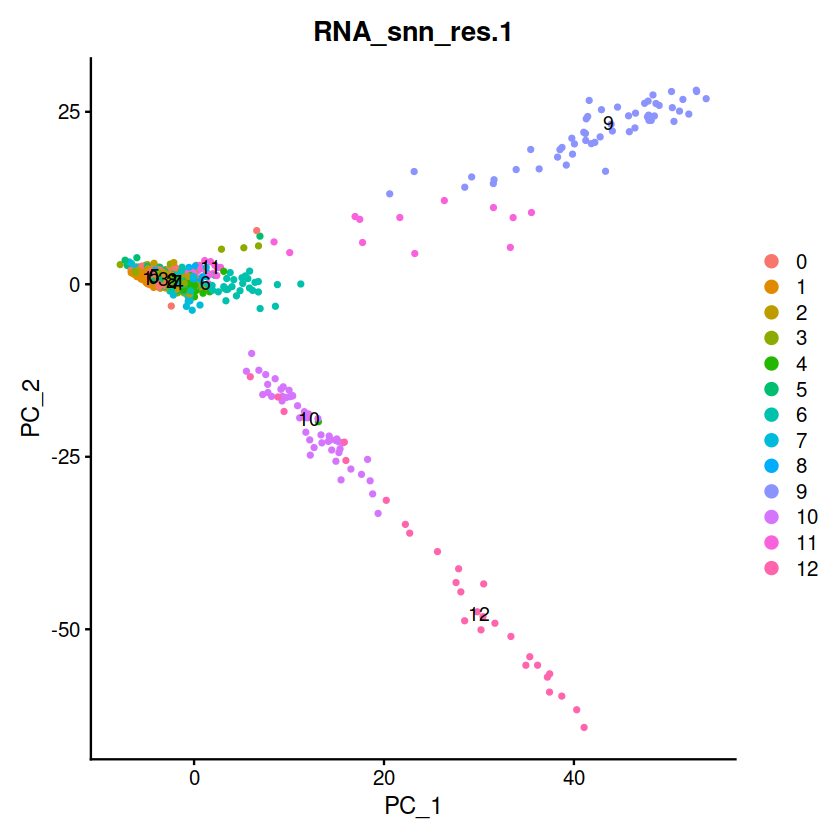

In [3]:
## step 12. clusters the cells 
# Now using the elbow method we determine the neighbours, make the clusters of neighbour and then ran the UMAP to plot the same
dat_seurat_obj_filtered <- FindNeighbors(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered, resolution = 1) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
View(dat_seurat_obj_filtered@meta.data)
DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.1", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.9", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.7", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.5", label=TRUE)
# optional step (to set the granularity of the data, i mean the number of clusters to be shown in UMAP)
## seeing or setting identity of clusters  
## Idents function store the identity of cluster
#head(Idents(dat_seurat_obj_filtered), 5) 
#Idents(dat_seurat_obj_filtered)
# when want to set the identity 
#Idents(dat_seurat_obj_filtered) <- SCLC_snn_res_0.3 ## this will set the resolution at 0.3 and make the only number of clusters which are in 0.3 resolution

## choosing best cluster using Dimplot, as above
Idents(dat_seurat_obj_filtered) <- "RNA_snn_res.1" ## setting increased resolution of cluster 
dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/UMAP.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)
dev.off()

png 
  2

png 
  2

Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR



NULL


png 
  2

[1] "Creating 506 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.02_102,DF.classifications_0.25_0.02_102
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>
AAACCTGAGCCTTGAT-1,SCLC,3819,2305,0.8379157,0.50737221,-0.1258182624,S,SCLC,0.6331904762,7,7,0.150,Singlet
AAACCTGTCACTCTTA-1,SCLC,807,206,1.3630731,-0.07101705,0.0500747270,G2M,SCLC,-0.1210917755,1,1,0.025,Singlet
AAACCTGTCCAGATCA-1,SCLC,512,457,0.1953125,0.01107701,0.2198765358,G2M,SCLC,-0.2087995211,0,0,0.200,Singlet
AAACCTGTCGGAAACG-1,SCLC,833,702,2.1608643,0.05817430,0.2454870416,G2M,SCLC,-0.1873127400,5,5,0.025,Singlet
AAACGGGGTACAGTGG-1,SCLC,7340,2459,1.7983651,-0.23035956,-0.1090290869,G1,SCLC,-0.1213304709,12,12,0.300,Doublet
AAAGATGCAGTCGTGC-1,SCLC,2679,1913,3.8820455,0.11616206,-0.0780450528,S,SCLC,0.1942071128,3,3,0.350,Doublet
AAAGATGGTCCAGTAT-1,SCLC,1907,1441,1.9926586,0.12147693,-0.2424572185,S,SCLC,0.3639341530,8,8,0.150,Singlet
AAAGATGTCACTATTC-1,SCLC,2293,1589,4.0122111,-0.14073396,0.0174769162,G2M,SCLC,-0.1582108757,5,5,0.175,Singlet
AAAGCAAAGACTGTAA-1,SCLC,3370,1954,1.6617211,0.14707943,-0.0927216655,S,SCLC,0.2398010908,2,2,0.250,Singlet


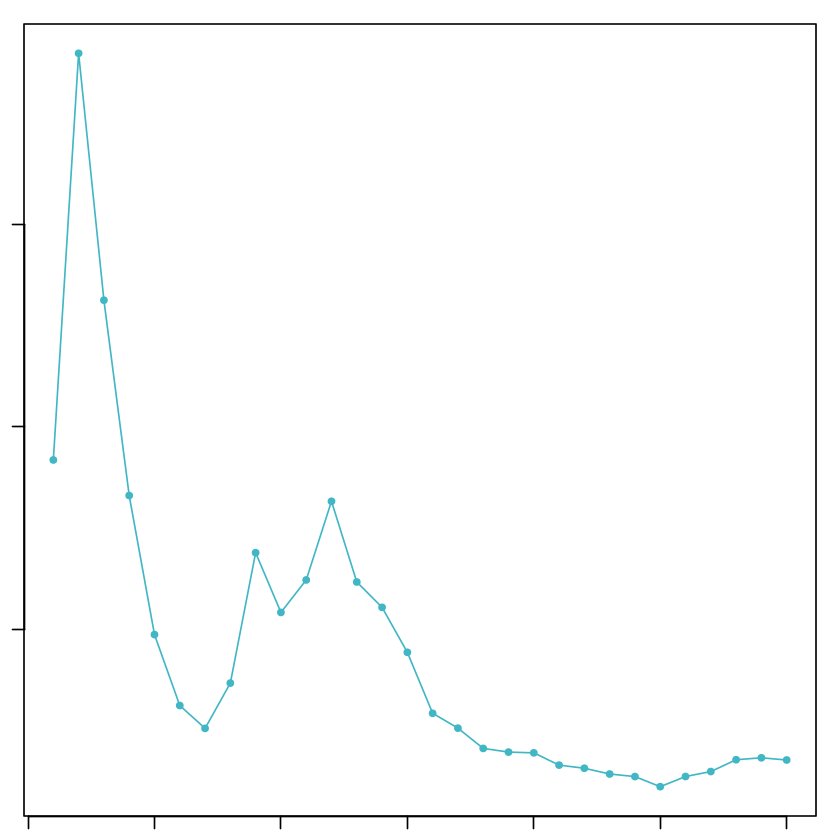

In [4]:
# Plotting for cell cycle scores
##### seeing the object formed for cell cycle scores ####
#head(dat_seurat_obj_filtered[[]])
#str(dat_seurat_obj_filtered)
#Getting Cell cycle scores from the seurat object 
S_score <- dat_seurat_obj_filtered@meta.data$S.Score
g2m_score <- dat_seurat_obj_filtered@meta.data$G2M.Score
cluster_info <- as.numeric(as.character(dat_seurat_obj_filtered@meta.data$seurat_clusters))
Phase <- dat_seurat_obj_filtered@meta.data$Phase
# View(S_score)
# View(g2m_score)
# View(cluster_info)
# View(Phase)
# making dataframe by combining relative stuff what we want to show in plot
cell_df <- cbind(cluster_info, Phase, g2m_score, S_score)

## converting to dataframe and calculating the percentage for stacked bar plot 
# link - https://rpubs.com/techanswers88/stackedbarcharts
cell_df <- data.frame(cell_df)
dt <- cell_df%>%
  dplyr::group_by(cluster_info, Phase)%>%
  dplyr::tally()%>%
  dplyr::mutate(percent=n/sum(n))

## plotting the result 
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_stack(vjust=0.5), colour="white", size = 2)


# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 ))
# pl
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/cell_cycle.jpg", width = 2000, height = 1200, res=300)
pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
pl <- pl + geom_bar(stat="identity", position ="fill")
pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
                     position=position_fill(vjust=0.5), colour="black", size =3)

pl <- pl + theme_minimal()
#pl <- pl + labs(title ="Cell cycle score for SCAF2229")
#pl <- pl + labs(subtitle ="plot")
pl <- pl + labs(caption ="Cell cycle score for SCAF2229")
pl <- pl  + labs(x ="Cluster", y = "Percentage")
pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 )) + coord_flip()
pl
dev.off()

### cell cycle plot without percent label
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/cell_cycle_SCAF2229.jpg", width = 2000, height = 1200, res=300)
ggplot(dt, aes(x = cluster_info, y = percent, fill = Phase))+
  geom_col()
dev.off()
### we finished with data pre-processing prior to any doublet finder --- Now we can go for doublet finder 
### Important points - 1. Doublet finder needs to be done on each sample separately, prior to aggregating 
## pk identification --- no ground truth approach
# link -- https://rdrr.io/github/chris-mcginnis-ucsf/DoubletFinder/man/doubletFinder_ParamSweep.html
# link - https://www.youtube.com/watch?v=NqvAS4HgmrE
## required packages 
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
#library(DoubletFinder)

## step 13. Doublet Finding
sweep.list_SCAF3163 <- paramSweep_v3(dat_seurat_obj_filtered, PCs =1:20, sct=FALSE)
sweep.stats_SCAF3163 <- summarizeSweep(sweep.list_SCAF3163, GT = FALSE)
bcmvn_SCAF3163 <- find.pK(sweep.stats_SCAF3163)

### plotting the results --- highest value in plot is your optimal pK
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/optimal_k.jpg", width = 3000, height = 2000, res=300)
ggplot(bcmvn_SCAF3163, aes(pK, BCmetric, group=1))+
geom_point()+
geom_line()
dev.off()


### storing the highest pk value to a pk variable
pK <- bcmvn_SCAF3163 %>%
      filter(BCmetric == max(BCmetric)) %>%
      select(pK)
pK <- as.numeric(as.character(pK[[1]]))


### Homotypic doublet proprotion estimation
annotations <- dat_seurat_obj_filtered@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)
nExp_poi <- round(0.076*nrow(dat_seurat_obj_filtered@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))


#### run Doubletfinder 
dat_seurat_obj_filtered <- doubletFinder_v3(dat_seurat_obj_filtered, PCs = 1:20, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
## Viewing data frame 
View(dat_seurat_obj_filtered@meta.data)

In [5]:
# before plotting we need to see following items in our data
names(dat_seurat_obj_filtered@meta.data)
# from there we got the DF.classification, which we need for plot
# homotypic.prop
nExp_poi ## number of expected doublets
nExp_poi.adj ## number of actual doublets

[1] "orig.ident"                       "nCount_RNA"                      
 [3] "nFeature_RNA"                     "percent.mt"                      
 [5] "S.Score"                          "G2M.Score"                       
 [7] "Phase"                            "old.ident"                       
 [9] "CC.Difference"                    "RNA_snn_res.1"                   
[11] "seurat_clusters"                  "pANN_0.25_0.02_102"              
[13] "DF.classifications_0.25_0.02_102"

[1] 115

[1] 102

In [6]:
### visulaize the doublets 
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.02_102")
dev.off()

## Step 13. Doublets removal
#since we have the name doublets in one of our meta data column of a "dat_seurat_obj_filtered@meta_data", this column has singlet and doublet information
#we can only select singlet by specifying values and so
#Link --- https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/seurat/seurat_01_qc.html
#data.filt = data.filt[, data.filt@meta.data[, DF.name] == "Singlet"]
data.filt = dat_seurat_obj_filtered[, dat_seurat_obj_filtered@meta.data[, "DF.classifications_0.25_0.02_102"] == "Singlet"]
#dim(data.filt)

### ploting the doublet removed dataset for PC & UMAP
#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/UMAP_doublets_removed.jpg", width = 3000, height = 2000, res=300)
#DimPlot(data.filt, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_145")
#dev.off()


### plotting the doublet removed dataset with cluster info 
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/without_doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(data.filt, reduction = "umap", label = TRUE)
dev.off()





png 
  2

png 
  2

In [7]:
## step 14. Finding differentially expressed features (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
# saving all the markers genes
write.csv(dat_filt.markers, file="/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_positive_marker_gene.csv")
# saving markers genes for a defined crieria
sub_df <- subset(dat_filt.markers, avg_log2FC > 2 & p_val < 0.05)
write.csv(sub_df, file="/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_positive_marker_gene_significant.csv")
# plotting the marker gene 
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/top5_markers.jpg", width = 5500, height = 3300, res=300)
dat_filt.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5
DoHeatmap(data.filt, features = top5$gene) + NoLegend()
dev.off()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.988687e-27,2.466409,0.440,0.186,7.332146e-23,0,KCNQ1OT1
2.089696e-20,2.410233,0.534,0.349,5.126652e-16,0,NEAT1
2.918320e-239,6.285648,0.987,0.061,7.159514e-235,1,HBA1
1.326184e-210,6.182826,1.000,0.125,3.253526e-206,1,HBB
3.456592e-78,5.056057,0.473,0.043,8.480056e-74,2,HSPA6
1.076216e-69,3.525832,0.888,0.396,2.640281e-65,2,DNAJB1
8.622297e-13,1.232892,0.527,0.297,2.115308e-08,3,TUBB2B
1.652105e-08,1.223878,0.250,0.106,4.053109e-04,3,TGIF1
7.142843e-76,3.140391,0.737,0.118,1.752354e-71,4,CEL


png 
  2

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
“The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application.”
Warning message:
“The following arguments are not used: scale.factor”
Centering and scaling data matrix

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

CytoTRACE will be run on 1 sub-sample(s) of approximately 1417 cells each using 1 / 1 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done

Warning message:
“The

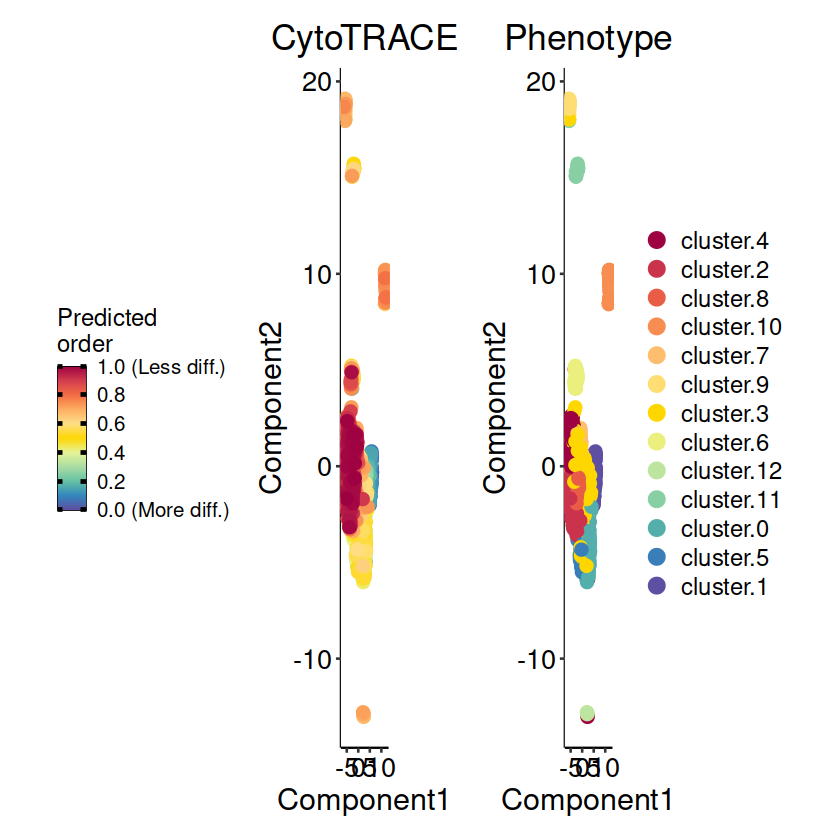

In [8]:
#### Cyotrace analysis starts from here ####
# Link - https://cytotrace.stanford.edu/
####
#install.packages("devtools")
#devtools::install_local("/data/kumarr9/CytoTRACE_0.3.3.tar.gz")
library(CytoTRACE)
#### Cyotrace needs the normalized seurat object
# mtrx should be non-negative(?) => seurat_obj should be normalized using scale.factor=1e6 instead of default (1e5)
seurat_obj <- ScaleData(data.filt, scale.factor=1e6 )
# seurat_obj <- RunPCA(seurat_obj)
# seurat_obj <- JackStraw(seurat_obj)
# seurat_obj <- ScoreJackStraw(seurat_obj)
# seurat_obj <- FindClusters(seurat_obj)
mtrx <- FetchData(seurat_obj, vars=rownames(seurat_obj))
mtrx <- t(mtrx)
## remove genes with 0 reads (of the genes included)
 genes.w.reads <- names(rowSums(mtrx)[rowSums(mtrx)>0])
 mtrx <- mtrx[genes.w.reads,]

 mtrx <- data.frame(mtrx)
 mtrx[mtrx=='.'] <- 0

# ##  outputs a list that includes CytoTRACE score per cell
 Cytotrace.out <- CytoTRACE(mtrx)

 meta <- paste0('cluster.', seurat_obj$seurat_clusters)
 names(meta) <- colnames(seurat_obj)
 names(meta) <- str_replace(names(meta), '-', '.')

# ## UMAP embeddings from Seurat
 umap.embeddings <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
 row.names(umap.embeddings) <- str_replace(row.names(umap.embeddings), '-', '.')

 cytotrace.plots <- plotCytoTRACE(Cytotrace.out, emb = umap.embeddings, phenotype = meta, outputDir = '/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/CytoTRACE.output.data')
#### Getting NE, Non-NE gene expression within each cluster of seurat object ####

# Provide a list of genes whose expression you want to see within each cluster
sclc_ne_genes <- c("ASCL1", "BEX1", "BSN", "CELF3", "CHGA", "CHGB","CRMP1", "FAM57B", "INSM1", "KIF1A", 
                   "KIF5C", "MYT1", "RTN1", "RUNDC3A", "SCG3","SEZ6", "SH3GL2", "SYN1", "SYP", "SYT11", 
                    "SYT4", "TAGLN3" ,"TFF3", "TMSB15A", "TMSB15B")
sclc_non_ne_genes <- c("ABCC3", "AHNAK", "ANXA1", "ARHGDIB", "CAV1","CAV2", "CCND1", "CYR61", "EMP1", "EPHA2",
                        "IFITM2", "IFITM3", "ITGB4", "LGALS3", "MYOF","PLAU", "PTGES", "RAB27B", "S100A10", "S100A16",
                        "SLC16A5", "TACSTD2", "TGFBI", "TGFBR2", "YAP1")

# Use the marker genes for each cluster identified in previous steps -
#dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_ne_genes),
                                   ctrl = 20,
                                   name = "neuro"
                                   )

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_non_ne_genes),
                                   ctrl = 20,
                                   name = "non_neuro"
                                   )


In [9]:
#Getting NE expression data
gene_data <- seurat_obj@meta.data$neuro1
cluster_info <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info <- as.numeric(cluster_info)
data_df <- cbind(gene_data, cluster_info)
data_df <- as.data.frame(data_df)
#data_df <- data.frame(gene_data, cluster_info)
# Set the plot title and y-axis label


gene_data2 <- seurat_obj@meta.data$non_neuro1
cluster_info2 <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info2 <- as.numeric(cluster_info2)
data_df2 <- cbind(gene_data2, cluster_info2)
data_df2 <- as.data.frame(data_df2)
#data_d2f <- data.frame(gene_data2, cluster_info2)

## Plotting starts from here 
ne <- ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, fill= factor(cluster_info))) +
  geom_violin() +
  labs(x = "Cluster", y = "Expression") + theme_minimal() + 
  ggtitle("NE gene expression by Cluster") + geom_hline(yintercept=0.00, linetype="dashed", color = "red")
ne1 <- ne + theme(legend.position = "none") ## added to remove the fill label
 non_ne <- ggplot(data_df2, aes(x = factor(cluster_info2), y = gene_data2, fill= factor(cluster_info2))) +
    geom_violin() +
    labs(x = "Cluster", y = "Expression") + theme_minimal() + 
    ggtitle("Non-NE gene expression by Cluster") + geom_hline(yintercept=0.00, linetype="dashed", color = "red")
non_ne1 <-  non_ne + theme(legend.position = "none") ## added to remove the fill label
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/NE_NonNE.jpg", width = 3000, height = 1500, res=300)
ggarrange(ne1, non_ne1, 
          ncol = 2, nrow = 1)
dev.off()

png 
  2

In [9]:
saveRDS(seurat_obj, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_cell_cycle_regress_difference_out_resolution_1.rds")

In [11]:
####################################################################
#### Working with saved object to create InferCNV plots and so #####
####################################################################

#### trying working with seurat object ---
## trying InferCNV from the saved .rds file
SCAF2229 <- readRDS("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_cell_cycle_regress_difference_out_resolution_1.rds")
load("/data/kumarr9/scRNA/PBMC_seu.RData")

## step 16. mergind the two seurat object 
# link - https://satijalab.org/seurat/articles/merge_vignette.html
# We are merging based on normalized one and hence added the parameters of merge.data=TRUE
SCAF2229_merged <- merge(SCAF2229, y = PBMC_seu, add.cell.ids = c("SCLC", "PBMC"), project = "SCLC",
     merge.data = TRUE)
# to see the content of merged object
# SCAF3163_merged@assays$RNA@counts
# dim(SCAF3163_merged)
# dim(SCAF3163)
# dim(PBMC_seu)

## step 17. Getting count matrix from merged dataframe
#str(SCAF3163_merged)
expr_matrix <- GetAssayData(object = SCAF2229_merged, slot = "counts", assay = "RNA")
# converting the expr_matrix which is dgCmatrix to dataframe 
expr_df <- as.data.frame(expr_matrix)
#expr_df[1:20, 1:20]
write.table(expr_df, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_matrix.csv", sep = "\t", row.names = TRUE, col.names = TRUE)
### creating gene order matrix for infercnv 
gene_names <- rownames(SCAF2229_merged)
### converted it to dataframe 
gene_names <- data.frame(gene_names)
## adding chromosme number, start and end to it
## read a gtf file ----
gtf_file <- read.table("/data/SCLCgenomics/rajesh/gene_version_27_cp.gtf")
matching_rows <- gtf_file[gtf_file$V5 %in% gene_names$gene_names, ]
### correcting this dataframe as given in inferCNV package
gene_df <- matching_rows %>% 
  dplyr::select(V5, everything())
gene_df <- gene_df[, -5]
gene_df = gene_df[!duplicated(gene_df$V5),]
# names(gene_df)[2] <- "chr"
# names(gene_df)[3] <- "start"
# names(gene_df)[4] <- "stop"

###
write.table(gene_df, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_gene_order.txt", sep = "\t", row.names = FALSE, col.names = FALSE)
## getting the cluster info from the seurat object/merged object
clust_info <- SCAF2229_merged@meta.data[, "seurat_clusters", drop=F]
## making dataset what looks like or needed by the inferCNV
clust_info$cellID <- rownames(clust_info)
clust_info$clstr <- paste0('cluster.', clust_info$seurat_clusters)
clust_info_df <- clust_info[, !names(clust_info) %in% "seurat_clusters"]
write.table(clust_info_df, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_annotation.txt", sep = "\t", row.names = FALSE, col.names = FALSE)



Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”


In [14]:
### running Infercnv with the script and then plotting result using the code below

#Below is the code for cnv score calculation after running inferCNV for the sample RU1311AT1 using cluster 2 as ref
# Read the infercnv result tableinto a matrix format
expr <- read.table(paste0("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/infercnv.observations.txt"), header=T) %>% as.matrix()
# Scale the expression matrix by subtracting the column means and dividing by the column standard deviations
expr.scale <- scale(t(expr))
# Subtract the minimum value of each column from the scaled expression matrix
tmp1 <- sweep(expr.scale, 2, apply(expr.scale, 2, min),'-')
# Calculate the range (maximum - minimum) of each column in the scaled expression matrix
tmp2 <- apply(expr.scale, 2, max) - apply(expr.scale,2,min)
# Normalize the scaled expression matrix to the range of -1 to 1
expr_1 <- t(2*sweep(tmp1, 2, tmp2, "/")-1)
# Calculate the CNV score by summing the squared values of each column in the normalized expression matrix
cnv_score <- as.data.frame(colSums(expr_1 * expr_1))
#head(cnv_score)
#### CNV score calculation ends here #######

###################################
### CNV plot starts from here #####
###################################
### before plotting, needs some sort of processing such as doing add rownames of cell ID to dataframe and assign name CellID to this
cnv_score <- tibble::rownames_to_column(cnv_score, var = "CellID")
colnames(cnv_score)[2] ="score"
# saving this dataframe for future use, if needed
write.table(cnv_score, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2229_cnv_score.txt", sep = "\t", row.names=FALSE)
## Since, the two dataframe i.e. cnv score dataset and annotation dataset has similar thing in terms of cellID but in different order
## so, make them in similar order
# Read File 1 into a data frame
file1 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2229_cnv_score.txt", header = TRUE)

# Read File 2 into a data frame
file2 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_annotation.txt", header = TRUE)
### make copy of the annotation file, since InferCNV needs the file without header and here we are adding header for plot and so
file2_cp <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_annotation.txt", header = FALSE)
# Add headers to the data
headers <- c("CellID", "Info")
colnames(file2_cp) <- headers
# save the annotation copied file with header info
write.table(file2_cp, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/annotation_cp.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [15]:
## Open the annotation_cp.txt file and check for the file1 and file3 has the same format of row
## in saved file change :%s/-/./g, so that file1 and file3 has same column
file3 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/annotation_cp.txt", header = TRUE)
# Merge File 1 and File 2 based on the cell ID column
merged <- merge(file1, file3, by = "CellID")

# Reorder the rows of File 1 based on the order in File 2
ordered_file1 <- merged[order(merged$CellID), ]

## save the dataframe for future use 
write.table(ordered_file1, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/cnv_score_ordered_annotation.txt", sep = "\t", row.names = FALSE)
### plotting the results ###
library(ggplot2)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2229_classic.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+ ggtitle("InferCNV estimation for SCAF2229") +
  labs(title="",x="Cluster", y = "CNV Scores") +  theme_classic() + theme(axis.text.x = element_text(angle = 30, hjust = 1)) 
dev.off()

png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2229_minimal.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+ ggtitle("InferCNV estimation for SCAF2229") +
  labs(title="",x="Cluster", y = "CNV Scores") + theme_minimal() + theme(axis.text.x=element_text(angle=30, hjust=1))
dev.off()


png 
  2

png 
  2

In [12]:
## This can be done just after # step 13, after removing doublets
### cluster_profiler analysis/plot starts from here 
# load libraries
library(clusterProfiler)
library(org.Hs.eg.db)
################
logFCfilter=0.5 ## define cutoff
adjPvalFilter=0.05
Cells.markers <- FindAllMarkers(data.filt, # the Seurat obejct
only.pos = TRUE,
min.pct = 0.25,
logfc.threshold = logFCfilter)
################
Cells.markers %>%
  group_by(cluster) %>%
  top_n(n = 200, wt = abs(avg_log2FC)) -> top100
top100$cluster <- factor(top100$cluster, levels = c("0", "1", "2", "3", "4", "5", "6")) ## change this to for number of clusters, this can be seen from UMAP plot 
eg = bitr(top100$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
top100 <- merge(top100, eg, by.x = "gene", by.y = "SYMBOL")
#################
cpr <- compareCluster(ENTREZID ~ cluster,
                      data = top100,
                      fun = "enrichGO",
                      OrgDb="org.Hs.eg.db"
)

## plot the result for clusterprofiler ####
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2229_cluster_profile.jpg", width = 4000, height = 2900, res=300)
dotplot(cpr, label_format = 100)+xlab("")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
  scale_color_viridis_c(option = "viridis", begin = 1, end = 0)+ ### change "viridis" to either "magma" or so link - https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
  theme_linedraw()
dev.off()



clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4


Attaching package: ‘stats4’


The following object is masked from ‘package:spam’:

    mle


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:spam’:

    cbind, rbind


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘pac

png 
  2

In [13]:
##Hallmark gene set analysis within clusters ###
library(msigdbr)
msigdbr_show_species()
### retrieving only human datasets ###
#Molecular Signatures Database is a collection of annotated gene sets. It contains 8 major collections:

# H: hallmark gene sets
# C1: positional gene sets
# C2: curated gene sets
# C3: motif gene sets
# C4: computational gene sets
# C5: GO gene sets
# C6: oncogenic signatures
# C7: immunologic signatures
cp.t2g <- clusterProfiler::read.gmt("/data/kumarr9/h.all.v2022.1.Hs.symbols.gmt")
#trying running for the enrichment analysis like before:
cpr_hall <- compareCluster(gene ~ cluster,
                      data = top100,
                      fun = "enricher",
                      TERM2GENE = cp.t2g,
                      minGSSize = 0,
                      maxGSSize = 5000)

## plot the result for clusterprofiler ####
# dotplot(cpr_hall, label_format = 100)+xlab("")+
#   theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
#   scale_color_viridis_c(option = "viridis", begin = 1, end = 0)+ ### change "viridis" to either "magma" or so link - https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
#   theme_linedraw()

## plot the result for clusterprofiler ####
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2229_hallmark.jpg", width = 4000, height = 2900, res=300)
dotplot(cpr_hall, label_format = 100)+xlab("")+
   theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
   scale_color_viridis_c(option = "viridis", begin = 1, end = 0)+ ### change "viridis" to either "magma" or so link - https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
   theme_linedraw()
dev.off()

Warning message:
“'msigdbr_show_species' is deprecated.
Use 'msigdbr_species' instead.
See help("Deprecated")”


[1] "Anolis carolinensis"             "Bos taurus"                     
 [3] "Caenorhabditis elegans"          "Canis lupus familiaris"         
 [5] "Danio rerio"                     "Drosophila melanogaster"        
 [7] "Equus caballus"                  "Felis catus"                    
 [9] "Gallus gallus"                   "Homo sapiens"                   
[11] "Macaca mulatta"                  "Monodelphis domestica"          
[13] "Mus musculus"                    "Ornithorhynchus anatinus"       
[15] "Pan troglodytes"                 "Rattus norvegicus"              
[17] "Saccharomyces cerevisiae"        "Schizosaccharomyces pombe 972h-"
[19] "Sus scrofa"                      "Xenopus tropicalis"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

In [ ]:
#### For scvelo required UMAP coordinates and cluster information #####

In [54]:
## Getting UMAP coordinates
SCAF2229 <- readRDS("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_cell_cycle_regress_difference_out_resolution_1.rds")
SCAF2229_coords <- SCAF2229$umap@cell.embeddings
SCAF2229_coords <- data.frame(SCAF2229_coords)
SCAF2229_coords <- tibble::rownames_to_column(SCAF2229_coords, "Barcode")
write.table(SCAF2229_coords, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_umap_coordinates.txt", sep = "\t", row.names = F, col.names = TRUE)

In [55]:
# Getting Seuart clusters
SCAF2229_cluster <- SCAF2229$seurat_clusters
SCAF2229_cluster <- data.frame(SCAF2229_cluster)
SCAF2229_cluster <- tibble::rownames_to_column(SCAF2229_cluster, "Barcode")
write.table(SCAF2229_cluster, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2229/alternate_cell_cycle_regress_out/SCAF2229_clusters.txt", sep = "\t", row.names = F, col.names = TRUE)
## File has been moved to .csv from .txt

In [57]:
SCAF2229[[]]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.02_102,DF.classifications_0.25_0.02_102,neuro1,non_neuro1
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
AAACCTGAGCCTTGAT-1,SCLC,3819,2305,0.8379157,0.507372214,-0.1258182624,S,SCLC,0.633190476,7,7,0.150,Singlet,0.297620838,-0.121396809
AAACCTGTCACTCTTA-1,SCLC,807,206,1.3630731,-0.071017048,0.0500747270,G2M,SCLC,-0.121091775,1,1,0.025,Singlet,0.026648472,-0.010901789
AAACCTGTCCAGATCA-1,SCLC,512,457,0.1953125,0.011077015,0.2198765358,G2M,SCLC,-0.208799521,0,0,0.200,Singlet,-0.099124352,-0.050789044
AAACCTGTCGGAAACG-1,SCLC,833,702,2.1608643,0.058174302,0.2454870416,G2M,SCLC,-0.187312740,5,5,0.025,Singlet,-0.086147779,-0.053893249
AAAGATGGTCCAGTAT-1,SCLC,1907,1441,1.9926586,0.121476934,-0.2424572185,S,SCLC,0.363934153,8,8,0.150,Singlet,0.140449512,-0.114150459
AAAGATGTCACTATTC-1,SCLC,2293,1589,4.0122111,-0.140733959,0.0174769162,G2M,SCLC,-0.158210876,5,5,0.175,Singlet,0.346848583,-0.120259267
AAAGCAAAGACTGTAA-1,SCLC,3370,1954,1.6617211,0.147079425,-0.0927216655,S,SCLC,0.239801091,2,2,0.250,Singlet,0.299515811,-0.064251881
AAAGCAAAGTATTGGA-1,SCLC,1386,1045,4.1125541,-0.198701140,-0.1348382930,G1,SCLC,-0.063862847,4,4,0.100,Singlet,0.107744081,-0.058840055
AAAGCAACACGCATCG-1,SCLC,2491,1630,1.7663589,-0.145037817,-0.0809949077,G1,SCLC,-0.064042910,4,4,0.100,Singlet,0.405664746,-0.109627058
